# Gold droplet hits substrate

Here, we will shoot a gold cluster onto a gold substrate and systematically study the effect of cluster size and velocity. A workflow involves

* Energy minimization of a substrate
* Equilibration of substrate (here in NVE ensemble)
* Energy minimization of a cluster
* Equilibration of cluster (here in NVE ensemble)
* Melting cluster at high temperature
* Shooting cluster onto substrate

![Gold droplet hits substrate workflow](fig/010_deposit_gold_cluster_zoom.png)

The subfolder `infiles` contains LAMMPS input scripts for each of these steps.

## Initialization

In [1]:
# to display plots directly inline within this notebook
%matplotlib inline  

In [2]:
# we might need these for
# * enforced memory clean-up (gc)
# * bash-like globbing of files on the local file system (glob)
# * basic stream-from-string input (io)
# * extracting interseting information from log files by regular expressions (re)
# * os, sys ...
import gc, glob, io, os, re, sys

In [3]:
import ase, ase.io, ase.visualize # read and visualize LAMMPS trajectories
import matplotlib.pyplot as plt   
import numpy as np                
import pandas as pd
import scipy as scp # here for handling rotations as matrices and quaternions
import scipy.spatial 
from pprint import pprint

In [4]:
# FireWorks functionality 
from fireworks import Firework, LaunchPad, ScriptTask, Workflow

# new here: tasks using FireWorks FilePad
from fireworks.user_objects.firetasks.filepad_tasks import AddFilesTask, GetFilesTask

# direct FilePad access, similar to the familiar LaunchPad:
from fireworks.utilities.filepad import FilePad 

In [5]:
prefix = os.getcwd()

In [6]:
# to start with
infile_prefix = os.path.join(prefix,'infiles')

In [7]:
# the FireWorks LaunchPad
lp = LaunchPad.auto_load() #Define the server and database

In [8]:
# FilePad behaves analogous to LaunchPad
fp = FilePad.auto_load()

In [9]:
# use this little snippet to identify large objects in memory
# delete them and, if necessary, call gc.collect() manually to free up memory
def memuse():
    """Quick overview on memory usage of objects in Jupyter notebook"""
    # https://stackoverflow.com/questions/40993626/list-memory-usage-in-ipython-and-jupyter
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    return sorted([(x, sys.getsizeof(globals().get(x))) for x in dir(sys.modules['__main__']) if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

## Static workflow

Within this demo, we arrange our input and data files in a data base
and attach metadata for easy querying. FireWorks readily offers the FilePad 
(based on an underlying MongoDB "GridFS") for such purposes.

In [10]:
# some unique identifier for our study
project_id = 'fireworks-hands-on-2019-12-09'

### Files

In [11]:
# input and data files for the current parametric study
files = {
    # one file describing the interatomic potential
    'potential':             'Au-Grochola-JCP05.eam.alloy',
    # two files for different cluster sizes
    'large_cluster':         'cluster_3871.lammps',
    'small_cluster':         'cluster_923.lammps',
    # several LAMMPS input files for the above steps
    'minimize_substrate':    'A_minimize_substrate.in',
    'equilibrate_substrate': 'B_equilibrate_substrate.in',
    'minimize_cluster':      'A_minimize_cluster.in',
    'equilibrate_cluster':   'B_equilibrate_cluster.in',
    'melt_cluster':          'C_melt_cluster.in',
    'deposit':               'D_deposit.in'
}

In [18]:
# metadata common to all these files 
metadata = {
    'project': project_id,
    'type': 'input'
}

In [19]:
fp_files = []

In [20]:
# insert these input files into data base
for name, file in files.items():
    file_path = os.path.join(infile_prefix,file)
    identifier = '/'.join((project_id,name)) # identifier is like a path on a file system
    metadata["name"] = name
    #fp.delete_file(identifier=identifier)
    fp_files.append( fp.add_file(file_path,identifier=identifier,metadata = metadata) )

In [21]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.type': 'input'
}

In [22]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

9

In [23]:
# we fixed simple identifiers of this form
print(identifier)

fireworks-hands-on-2019-12-09/deposit


In [24]:
# on a lower level, each object has a unique "GridFS id":
pprint(fp_files) # underlying GridFS id and readable identifiers

[('5ded279c11940f1ec729018a', 'fireworks-hands-on-2019-12-09/potential'),
 ('5ded279c11940f1ec729018d', 'fireworks-hands-on-2019-12-09/large_cluster'),
 ('5ded279c11940f1ec7290190', 'fireworks-hands-on-2019-12-09/small_cluster'),
 ('5ded279c11940f1ec7290193',
  'fireworks-hands-on-2019-12-09/minimize_substrate'),
 ('5ded279c11940f1ec7290196',
  'fireworks-hands-on-2019-12-09/equilibrate_substrate'),
 ('5ded279c11940f1ec7290199', 'fireworks-hands-on-2019-12-09/minimize_cluster'),
 ('5ded279c11940f1ec729019c',
  'fireworks-hands-on-2019-12-09/equilibrate_cluster'),
 ('5ded279c11940f1ec729019f', 'fireworks-hands-on-2019-12-09/melt_cluster'),
 ('5ded279c11940f1ec72901a2', 'fireworks-hands-on-2019-12-09/deposit')]


In [25]:
# if necessary, remove all files matching query
# fp.delete_file_by_query(query)

### Build workflow

We have each FireWork prepared in a static yaml file within this folder, 
such as 

```yaml
fw_id: -10
name: "Minimize substrate"
spec:
  _category: "bwcloud_noqueue"
  _files_out: 
     data_file: final.lammps
  _tasks:
  - _fw_name: GetFilesTask
    identifiers:
    - fireworks-hands-on-2019-12-09/potential
    new_file_names:
    - Au-Grochola-JCP05.eam.alloy
  - _fw_name: GetFilesTask
    identifiers:
    - fireworks-hands-on-2019-12-09/minimize_substrate
    new_file_names:
    - lammps.in
  - _fw_name: ScriptTask
    script: source /etc/profile; module load LAMMPS; mpirun -n 2 lmp -in lammps.in
```

Notice the two `GetFilesTask`s. They query files by their identifier and put them in the task's working directory.
This is an alternative to `FileTransferTask`.

In [26]:
# We have each FireWork prepared in a static yaml file within this folder.
# Now, we read these and fix the dependencies here:

fw_A_substrate = Firework.from_file('A_substrate.yaml',)
fw_B_substrate = Firework.from_file('B_substrate.yaml')

fw_A_cluster   = Firework.from_file('A_cluster.yaml')
fw_B_cluster   = Firework.from_file('B_cluster.yaml')
fw_C_cluster   = Firework.from_file('C_cluster.yaml')

fw_D_deposit   = Firework.from_file('D_deposit.yaml')

wf = Workflow(
    [ fw_A_substrate, fw_B_substrate, 
      fw_A_cluster, fw_B_cluster, fw_C_cluster,
      fw_D_deposit ],
    
    { fw_A_substrate: fw_B_substrate, 
      fw_B_substrate: fw_D_deposit,
     
      fw_A_cluster:   fw_B_cluster, 
      fw_B_cluster:   fw_C_cluster,
      fw_C_cluster:   fw_D_deposit },
    
    name = "Gold cluster impact")

In [27]:
# we can write a static yaml file and have a look at, then submit it
# on the command line with "lpad add wf.yaml"...
wf.to_file('wf.yaml')

In [28]:
# or directly submit from here
fw_ids = lp.add_wf(wf)

2019-12-08 17:41:43,074 INFO Added a workflow. id_map: {-60: 23568, -50: 23569, -40: 23570, -30: 23571, -20: 23572, -10: 23573}


### Query results

Look at `D_deposit.yaml`. The final FireWork in this workflow uses
`AddFilesTask`s like this
```yaml
  - _fw_name: AddFilesTask
    paths: 
    - traj.dump
    compress: True
    metadata: 
      project:  fireworks-hands-on-2019-12-09
      type:     trajectory
      velocity: -25
      steps:    4000
      timestep: 0.001
```
to store files in the FilePad and attach metadata. We can use such metadata to query the output files after the workflow has run.

In [29]:
query = { 
    "metadata.project": project_id,
    "metadata.velocity": -25,
    "metadata.steps"   : 4000
}

In [30]:
# use underlying MongoDB functionality 
fp.filepad.count_documents(query)

3

In [33]:
query = { 
    "metadata.project": project_id,
    "metadata.velocity": -25,
    "metadata.steps"   : 4000,
    "metadata.type":             'final configuration'
}

In [34]:
config_file, config_metadata = fp.get_file_by_query(query)[0]

In [35]:
pprint(config_metadata)

{'_id': ObjectId('5ded286311940f336850cb3f'),
 'compressed': True,
 'gfs_id': '5ded286311940f336850cb3b',
 'identifier': '/mnt/dat/fw/launcher_2019-12-08-16-42-47-414867/final.lammps',
 'metadata': {'project': 'fireworks-hands-on-2019-12-09',
              'steps': 4000,
              'timestep': 0.001,
              'type': 'final configuration',
              'velocity': -25},
 'original_file_name': 'final.lammps',
 'original_file_path': '/mnt/dat/fw/launcher_2019-12-08-16-42-47-414867/final.lammps'}


In [36]:
# use ASE to read and visualize this final configuration
final_config = ase.io.read(
    io.StringIO(config_file.decode()),
    format='lammps-data',
    style='atomic',
    Z_of_type={1 : ase.data.atomic_numbers['Au']})

In [38]:
# rotate around y axis
roty = np.array(
    [[0,0,1],
     [0,1,0],
     [-1,0,0]])

In [39]:
# convert rotation matrix to quaternion
rot = scp.spatial.transform.Rotation.from_dcm(roty)

In [40]:
# circle leftwards for ngl quaternion representation
nglrot = list(np.roll(rot.as_quat(),-1))

In [42]:
v = ase.visualize.view(final_config,viewer='ngl')
v.view.remove_unitcell()
v.view.control.rotate(nglrot)
v.view.center()
v

## Parametric study

The true advantage of arrag of arranging files as objects within a data base is the
comparably comfortable evalutation of parametric studies. For this purpose, we prepare 
a simple parametric sweep across different cluster sizes and velocities in the above study:
![Parametric study workflow](fig/020_deposit_gold_cluster_parametric_study_zoom.png)

### Build workflow

We have two gold cluster data files, one small cluster with 923 atoms and one larger cluster with 3871 atoms.
In this parametric study, we want to shoot the small cluster at 25 Angstrom / ps, but for the large cluster two vleocities are to be probed. In the following, we generate a workflow corresponding to the previous one, now branching at the cluster energy minimization step for different cluster sizes, and branching again at the last step for shooting the cluster at several velocities. Cluster size and velocity are attached to the output files as metadata, just as shown above, e.g. as

```yaml
    - _fw_name: AddFilesTask
      compress: true
      metadata:
        cluster: large_cluster
        cluster_size: 3871
        material: gold
        project: fireworks-hands-on-2019-12-09
        type: trajectory
        velocity: -50
      paths: traj.dump
```

In [43]:
# parametric study in two dimensions: cluster size and cluster velocity
clusters = {
    'small_cluster': {'cluster_size': 923}, # number of atoms
    'large_cluster': {'cluster_size': 3871}
    }

# depending on cluster size, we look at different sets of velocities:
cluster_velocities_dict =  { 
    'small_cluster': [-25],
    'large_cluster': [-25,-50] } # cluster approach velocity, Angtsrom / ps

In [44]:
# build workflow to span two parametric dimensions "cluster size" and "velocity"
fws = []
parent_child_deps = {}

# default tasks:
get_potential_task = GetFilesTask(
        identifiers = ['/'.join((project_id ,'potential'))],
        new_file_names = ['Au-Grochola-JCP05.eam.alloy'] )

run_lammps_task = ScriptTask.from_str('''
    source /etc/profile; 
    module load LAMMPS; 
    mpirun -n 2 lmp -in lammps.in
    ''')

# substrate stays the same for all runs

# ------------------
# Minimize substrate
# ------------------

# define two tasks in Firework: Minimize substrate
# - GetFilesByQueryTask * 2
# - ScriptTask
ft = [ 
    get_potential_task, 
    GetFilesTask(
        identifiers = ['/'.join((project_id ,'minimize_substrate'))],
        new_file_names = ['lammps.in'] ) ]

fw_A_substrate = Firework( 
    [*ft, run_lammps_task], 
    name="Minimize substrate",
    spec = { 
        '_category': "bwcloud_noqueue",
        '_files_out': {'data_file': "final.lammps"},
        'metadata': {
            'project': project_id,
            'step': 'minimize_substrate' } } )

# ---------------------
# equilibrate substrate
# ---------------------

# define two tasks in Firework: Equilibrate substrate
# - FileTransferTask
# - ScriptTask
ft = [ 
    get_potential_task, 
    GetFilesTask(
        identifiers = ['/'.join((project_id ,'equilibrate_substrate'))],
        new_file_names = ['lammps.in'] ) ]

fw_B_substrate = Firework( 
    [*ft, run_lammps_task], 
    name="Equilibrate substrate",
    spec={
        '_category': "bwcloud_noqueue",
        '_files_in':  {'data_file': "initial.lammps"},
        '_files_out': {'data_file_substrate': "final.lammps"},
        'metadata': {
            'project': project_id,
            'step': 'equlibrate_substrate' } } )

fws.extend( [ fw_A_substrate, fw_B_substrate ] )
parent_child_deps.update( { 
        fw_A_substrate: [ fw_B_substrate ],
        fw_B_substrate: [] } )

for cluster, metadata in clusters.items():
    
    # ----------------
    # Minimize cluster
    # ----------------
    
    # define four tasks in Firework: Minimize cluster
    # - FileTransferTask * 3
    # - ScriptTask
    ft = [ 
        get_potential_task, 
        GetFilesTask(
            identifiers = ['/'.join((project_id ,cluster))],
            new_file_names = ['initial.lammps'] ),
        GetFilesTask(
            identifiers = ['/'.join((project_id ,'minimize_cluster'))],
            new_file_names = ['lammps.in'] ) ]

    fw_A_cluster = Firework(
        [*ft, run_lammps_task], 
        name = "Minimize cluster, N = {:d}".format(metadata["cluster_size"]),
        spec = { 
            '_category': "bwcloud_noqueue",
            '_files_out': { 'data_file': "final.lammps" },
            'metadata': {
                'project':      project_id,
                'step':         'minimize_cluster',
                'cluster':      cluster,
                'cluster_size': metadata["cluster_size"] } } )
    
    # -------------------
    # Equilibrate cluster
    # -------------------

    # define two tasks in Firework: Equilibrate cluster
    # - FileTransferTask
    # - ScriptTask
    ft = [ 
        get_potential_task, 
        GetFilesTask(
            identifiers = ['/'.join((project_id ,'equilibrate_cluster'))],
            new_file_names = ['lammps.in'] ) ]

    fw_B_cluster = Firework(
        [*ft, run_lammps_task], 
        name = "Equilibrate cluster, N = {:d}".format(metadata["cluster_size"]),
        spec = {
            '_category': "bwcloud_noqueue",
            '_files_in': { 'data_file': "initial.lammps" },
            '_files_out': {'data_file': "final.lammps" },
            'metadata': {
                'project':      project_id,
                'step':         'equilibrate_cluster',
                'cluster':      cluster,
                'cluster_size': metadata["cluster_size"] } } )
    
    # ------------
    # Melt cluster
    # ------------

    # define two tasks in the Firework: Melt cluster
    # - FileTransferTask
    # - ScriptTask
    ft = [ 
        get_potential_task, 
        GetFilesTask(
            identifiers = ['/'.join((project_id ,'melt_cluster'))],
            new_file_names = ['lammps.in'] ) ]
    
    fw_C_cluster = Firework(
        [*ft, run_lammps_task], 
        name = "Melt cluster, N = {:d}".format(metadata["cluster_size"]),
        spec = {
            '_category': "bwcloud_noqueue",
            '_files_in':  { 'data_file': "initial.lammps" },
            '_files_out': { 'data_file_cluster': "final.lammps" },
            'metadata': {
                'project':      project_id,
                'step':         'melt_cluster',
                'cluster':      cluster,
                'cluster_size': metadata["cluster_size"] } } )
    
    fws.extend( [ fw_A_cluster, fw_B_cluster, fw_C_cluster ] )
    parent_child_deps.update( {
            fw_A_cluster: [ fw_B_cluster ], 
            fw_B_cluster: [ fw_C_cluster ],
            fw_C_cluster: [] } )

    for velocity in cluster_velocities_dict[cluster]:
        #steps = velocity_steps_dict[velocity]
        
        # ----------------------------
        # Deposit cluster on substrate
        # ----------------------------
    
        # define five tasks in the Firework: Deposit
        # - FileTransferTask
        # - ScriptTask
        # - AddFilesTask * 3
        ft = [ 
        get_potential_task, 
        GetFilesTask(
            identifiers = ['/'.join((project_id ,'deposit'))],
            new_file_names = ['lammps.in'] ) ]

        st = ScriptTask.from_str('''
            source /etc/profile; 
            module load LAMMPS; 
            mpirun -n 2 lmp -in lammps.in -v vel {vel:}
            '''.format( vel=velocity ) ) # modify LAMMPS call to override parameters here!

        at = [ 
            AddFilesTask( {
                'compress':True ,
                'paths': "final.lammps",
                'metadata': {
                    'project':      project_id,
                    'type':         'final configuration',
                    'material':     'gold',
                    'velocity':      velocity,
                    'cluster':       cluster,
                    'cluster_size':  metadata["cluster_size"]} } ),
            AddFilesTask( {
                'compress':True ,
                'paths': "traj.dump",
                'metadata': {
                    'project':      project_id,
                    'type':         'trajectory',
                    'material':     'gold',
                    'velocity':      velocity,
                    'cluster':       cluster,
                    'cluster_size':  metadata["cluster_size"]} } ),
            AddFilesTask( {
                'compress':True ,
                'paths': "log.lammps",
                'metadata': {
                    'project':      project_id,
                    'type':         'log',
                    'material':     'gold',
                    'velocity':      velocity,
                    'cluster':       cluster,
                    'cluster_size':  metadata["cluster_size"]} } ) ]  

        fw_D_deposit = Firework(
            [*ft, st, *at],
            name = "Deposit, N = {:d}, v = {:.2f}".format(metadata["cluster_size"],velocity), 
            spec = {
                '_category': "bwcloud_noqueue",
                '_files_in':  { 
                    'data_file_cluster':   "cluster.lammps",
                    'data_file_substrate': "substrate.lammps" },
                'metadata': {
                    'project':      project_id,
                    'step':         'deposit',
                    'cluster':      cluster,
                    'cluster_size': metadata["cluster_size"],
                    'velocity':     velocity} } )
        
        fws.extend( [ fw_D_deposit ] )
        parent_child_deps[fw_B_substrate].append( fw_D_deposit )
        parent_child_deps[fw_C_cluster].append( fw_D_deposit )

In [45]:
wf = Workflow( fws, parent_child_deps, name = "Gold cluster impact parametric study")

In [46]:
wf.to_file('wf_parametric.yaml')

In [47]:
fw_ids = lp.add_wf(wf)

2019-12-08 17:49:09,018 INFO Added a workflow. id_map: {-11: 23574, -10: 23575, -9: 23576, -8: 23577, -7: 23578, -6: 23579, -5: 23580, -4: 23581, -3: 23582, -2: 23583, -1: 23584}


### Results overview 

In [50]:
query = { "metadata.project": project_id }

In [51]:
# use underlying MongoDB functionality 
fp.filepad.count_documents(query)

21

In [54]:
# query all files of type "trajectory" within project
query = { 
    "metadata.project": project_id,
    "metadata.material": "gold",
    "metadata.type":    "trajectory"}

In [55]:
fp.filepad.count_documents(query) 
# that many documents matching query

3

Now, we can use aggregation to get an overivew of the unique result datasets:

In [56]:
# use aggregation to determine unique parameter sets
# see https://docs.mongodb.com/manual/aggregation

# first filter all files by a general query, here as above
# all trajectories in project
match_aggregation = {
        "$match": query
    }

In [57]:
# group by parameters of interest, i.e. cluster_size and velocity:
group_aggregation = { 
    "$group": { 
        "_id": { 
            "cluster_size": "$metadata.cluster_size", 
            "velocity":     "$metadata.velocity"
        }
    } 
}

In [58]:
aggregation_pipeline = [ match_aggregation, group_aggregation ]

In [59]:
# this aggregation yields all unique parameter sets as documents
cursor = fp.filepad.aggregate(aggregation_pipeline)

In [60]:
# we sort these sets by cluster_size
unique_parameter_sets = [ c["_id"] for c in sorted(
        cursor, key=lambda d: d["_id"]["cluster_size"]) ]

Thereby, we get a simple overview on the unique combinations of parameters "cluster_size" and "velocity" that reside in our database:

In [61]:
unique_parameter_sets

[{'cluster_size': 923, 'velocity': -25},
 {'cluster_size': 3871, 'velocity': -25},
 {'cluster_size': 3871, 'velocity': -50}]

In [62]:
# next, we use a bit of cryptic pandas formatting to get a simple
# two-dimensional visualization of existing and non-existing
# data sets
unique_parameter_sets_df = pd.DataFrame(unique_parameter_sets)
parameter_set_overview = unique_parameter_sets_df.groupby( 
    list(unique_parameter_sets_df.columns) ).size().unstack(
    fill_value=0).astype(bool).style.applymap(
    lambda v: 'color: {}'.format('green' if v else 'red'))

In [63]:
parameter_set_overview

Thsi might look like overkill for only two parameters, but will help to keep an overview when mapping out a high-dimensional parametric space.

### Results anaylsis

With properly formulated queries, evaluating the results selectively becomes easy.

#### Large cluster

In [64]:
# query a specific "trajectory" file
query = { 
    "metadata.project":      project_id,
    "metadata.type":         "trajectory",
    "metadata.velocity":     -25,
    "metadata.cluster_size": 3871}

In [65]:
print(fp.filepad.count_documents(query) )
# that many documents matching query

1


In [66]:
# the FilePad yields trajectory and attached metadata
traj_file, traj_metadata = fp.get_file_by_query(query)[0]

In [67]:
pprint(traj_metadata)

{'_id': ObjectId('5ded2ad811940f336850cbe5'),
 'compressed': True,
 'gfs_id': '5ded2ad611940f336850cbaa',
 'identifier': '/mnt/dat/fw/launcher_2019-12-08-16-53-00-210573/traj.dump',
 'metadata': {'cluster': 'large_cluster',
              'cluster_size': 3871,
              'material': 'gold',
              'project': 'fireworks-hands-on-2019-12-09',
              'type': 'trajectory',
              'velocity': -25},
 'original_file_name': 'traj.dump',
 'original_file_path': '/mnt/dat/fw/launcher_2019-12-08-16-53-00-210573/traj.dump'}


In [68]:
traj_large = ase.io.read(
    io.StringIO(traj_file.decode()),
    format='lammps-dump-text',
    index=':',
    specorder=[ase.data.atomic_numbers['Au']])

In [69]:
w = ase.visualize.view(traj_large, viewer='ngl')
w.view.remove_unitcell()
w.view.control.rotate(nglrot)
w.view.center()
w.view.control.zoom(-1)

#### Small cluster

In [70]:
# query a specific "trajectory" file
query = { 
    "metadata.project":      project_id,
    "metadata.type":         "trajectory",
    "metadata.velocity":     -25,
    "metadata.cluster_size":923}

In [71]:
print(fp.filepad.count_documents(query) )
# that many documents matching query

1


In [72]:
traj_file, traj_metadata = fp.get_file_by_query(query)[0]

In [73]:
pprint(traj_metadata)

{'_id': ObjectId('5ded2b3411940f336850cc20'),
 'compressed': True,
 'gfs_id': '5ded2b3111940f336850cbf3',
 'identifier': '/mnt/dat/fw/launcher_2019-12-08-16-54-48-943523/traj.dump',
 'metadata': {'cluster': 'small_cluster',
              'cluster_size': 923,
              'material': 'gold',
              'project': 'fireworks-hands-on-2019-12-09',
              'type': 'trajectory',
              'velocity': -25},
 'original_file_name': 'traj.dump',
 'original_file_path': '/mnt/dat/fw/launcher_2019-12-08-16-54-48-943523/traj.dump'}


In [74]:
traj_small = ase.io.read(
    io.StringIO(traj_file.decode()),
    format='lammps-dump-text',
    index=':',
    specorder=[ase.data.atomic_numbers['Au']])

In [75]:
v = ase.visualize.view(traj_small, viewer='ngl')
v.view.remove_unitcell()
v.view.control.rotate(nglrot)
v.view.center()
v.view.control.zoom(-1)
v

In [76]:

w

#### Selective analyisis at fixed cluster size

Here, we take a slice at fixed cluster size and compare thermodynamic 
observables along the trajectroies for slow and fast impact velocity.

In [77]:
# Compare along velocity dimension

In [78]:
# query a specific "trajectory" file
query = { 
    "metadata.project":      project_id,
    "metadata.material":     "gold",
    "metadata.type":         "log",
    "metadata.cluster_size": 3871}

In [79]:
print(fp.filepad.count_documents(query) )
# that many documents matching query

2


In [80]:
files = fp.get_file_by_query(query)

In [81]:
# Interseting thermodynamic data in LAMMPS log occurs between a table header 
# line always starting with "step", e.g. "Step KinEng PotEng TotEng Temp" and
# a concluding line always starting with "Loop", e.g. "Loop time of 111.167 
# on 2 procs for 4000 steps with 12671 atoms". We use this knowledge to
# extract this table with a regular expression:
regex = re.compile("(^Step(?:.(?!^Loop))*)", re.MULTILINE | re.DOTALL)

In [82]:
data = pd.DataFrame()
for content, metadata in files:
    m = regex.findall(content.decode())[0] # takes the first thermo output block
    
    d = pd.read_csv(io.StringIO(m),sep='\s+')
    d["velocity"] = metadata["metadata"]["velocity"]

    data = data.append(d,ignore_index=True)

In [83]:
columns = ['KinEng', 'PotEng','Temp', 'Press',]

In [84]:
V = data.velocity.unique() # unique velocities, should be -25 and -50

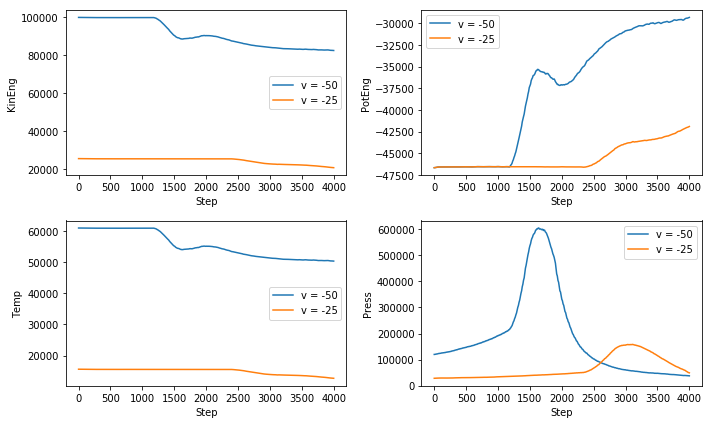

In [85]:
cols = 2
rows = 2
fig, ax = plt.subplots(rows,cols,figsize=(10,6))
for i,c in enumerate(columns): 
    ind = (i//cols,i%cols)
    for v in V:
        data[ data.velocity == v ].plot(
            ax=ax[ind],x="Step",y=c, label = "v = {:d}".format(v))
    ax[ind].set_ylabel(c)
fig.tight_layout()

#### Selective analyisis at fixed velocity

Similarly, we analyisistake a slice at fixed velocity v = -25 and compare thermodynamic 
observables along the trajectroies of large and small cluster.

In [86]:
# Compare along cluster size dimension

In [91]:
# query a specific "trajectory" file
query = { 
    "metadata.project":      project_id,
    "metadata.material":     "gold",
    "metadata.type":         "log",
    "metadata.velocity":     -25}

In [92]:
print(fp.filepad.count_documents(query) )
# that many documents matching query

2


In [93]:
files = fp.get_file_by_query(query)

In [94]:
data = pd.DataFrame()
for content, metadata in files:
    m = regex.findall(content.decode())[0] # takes the first thermo output block
    
    d = pd.read_csv(io.StringIO(m),sep='\s+')
    d["cluster_size"] = metadata["metadata"]["cluster_size"]

    data = data.append(d,ignore_index=True)

In [95]:
N = data.cluster_size.unique() # unique cluster sizes

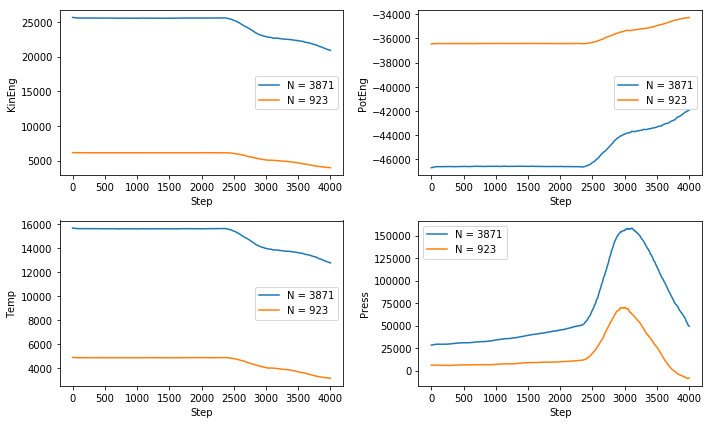

In [96]:
cols = 2
rows = 2
fig, ax = plt.subplots(rows,cols,figsize=(10,6))
for i,c in enumerate(columns): 
    ind = (i//cols,i%cols)
    for n in N:
        data[ data.cluster_size == n ].plot(
            ax=ax[ind],x="Step",y=c, label = "N = {:d}".format(n))
    ax[ind].set_ylabel(c)
fig.tight_layout()

Here, storing data sets within FireWork's FilePad with proper metadata attached facilitates meaningful evaluation.